In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [2]:
def load_results_dataframe(dir: Path, pattern: str) -> pd.DataFrame:
    """
    Walks dir for files named 'episodes_*.json', loads them,
    and returns a single DataFrame with columns:
      - all keys from your JSON records
      - 'source_file': the filename each record came from
      - 'modified_time': a pandas.Timestamp of the file’s mtime
    
    Rows are sorted by modified_time (most recent first).
    """
    records = []
    
    # 1) list files oldest → newest
    files = sorted(
        dir.glob(pattern),
        key=lambda p: p.stat().st_mtime,
    )
    
    for file_idx, path in enumerate(files):
        mtime = pd.to_datetime(path.stat().st_mtime, unit="s")
        content = json.loads(path.read_text())
        
        if isinstance(content, list):
            for entry_idx, entry in enumerate(content):
                rec = dict(entry)
                rec.update({
                    "source_file":   path.name,
                    "modified_time": mtime,
                    "file_index":    file_idx,
                    "entry_index":   entry_idx,
                })
                records.append(rec)
        
        elif isinstance(content, dict):
            rec = dict(content)
            rec.update({
                "source_file":   path.name,
                "modified_time": mtime,
                "file_index":    file_idx,
                "entry_index":   0,
            })
            records.append(rec)
        
        else:
            # fallback for other JSON shapes
            records.append({
                "source_file":   path.name,
                "modified_time": mtime,
                "file_index":    file_idx,
                "entry_index":   0,
                "data":          content,
            })
    
    df = pd.DataFrame(records)
    # row‐order == episode‐order
    return df

def load_episodes_dataframe(dir: Path) -> pd.DataFrame:
    return load_results_dataframe(dir=dir, pattern="episodes_*.json")

In [3]:
training_dir = Path("./outputs/1753592624458505983")

In [4]:
training_params = json.load(open(training_dir / "training_params.json", "r"))
for k, v in training_params.items():
    print(f"{k}: {v}")

n_episodes: 5000000
pretrained_dir: None
seed: 42
learning_rate_max: 0.5
learning_rate_min: 0.01
learning_rate_decay_rate: 0.99
epsilon_max: 1.0
epsilon_min: 0.1
epsilon_decay_rate: 0.99
opponent: RANDOM_AGENT
training: 2


In [5]:
episodes = load_episodes_dataframe(training_dir)
episodes.head()

,n_updates,mean_td_error,mean_abs_td_error,mean_squared_td_error,max_abs_td_error,final_reward,source_file,modified_time,file_index,entry_index
0,2,0.00,0.00,0.00,0.0,-1.0,episodes_0.json,2025-07-27 05:03:44.465080500,0,0
1,3,0.00,0.00,0.00,0.0,-1.0,episodes_500000.json,2025-07-27 05:04:48.785615683,1,0
2,4,0.00,0.00,0.00,0.0,-0.0,episodes_500000.json,2025-07-27 05:04:48.785615683,1,1
3,4,0.25,0.25,0.25,1.0,1.0,episodes_500000.json,2025-07-27 05:04:48.785615683,1,2
4,4,0.00,0.00,0.00,0.0,-0.0,episodes_500000.json,2025-07-27 05:04:48.785615683,1,3


In [6]:
len(episodes)

5000000

In [7]:
def get_moving_window_average(data: np.ndarray, window_size: int):
    weights = np.ones(window_size) / window_size
    moving_avg = np.convolve(data, weights, mode='valid')
    return moving_avg

In [8]:
codes = (episodes["final_reward"].astype(int) + 1).to_numpy()

# counts[0] = losses, counts[1] = ties, counts[2] = wins
counts = np.bincount(codes, minlength=3)

loss_count, tie_count, win_count = counts
total_count = counts.sum()

print(f"wins:   {win_count}")
print(f"ties:   {tie_count}")
print(f"losses: {loss_count}")
print(f"total_count: {total_count}")
assert total_count == len(episodes)

wins:   2840391
ties:   982142
losses: 1177467
total_count: 5000000


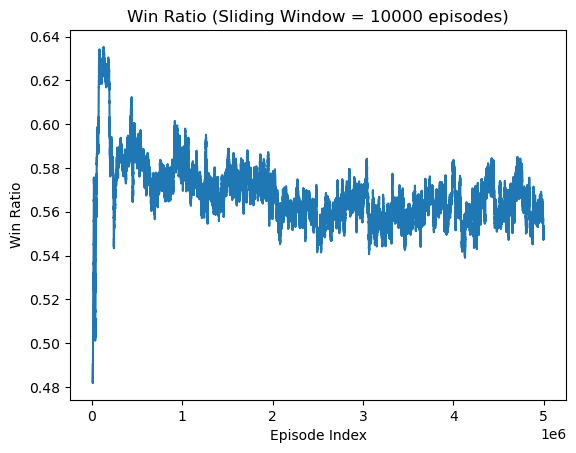

In [16]:
win_ratio = episodes["final_reward"].eq(1.0).rolling(window=10000).mean()

plt.figure()
plt.plot(win_ratio)
plt.title(f"Win Ratio (Sliding Window = {10000} episodes)")
plt.xlabel("Episode Index")
plt.ylabel("Win Ratio")
plt.show()

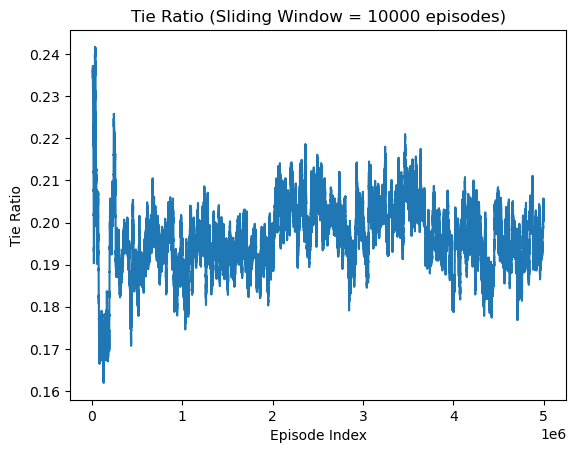

In [14]:
tie_ratio = episodes["final_reward"].eq(0.0).rolling(window=10000).mean()

plt.figure()
plt.plot(tie_ratio)
plt.title(f"Tie Ratio (Sliding Window = {10000} episodes)")
plt.xlabel("Episode Index")
plt.ylabel("Tie Ratio")
plt.show()


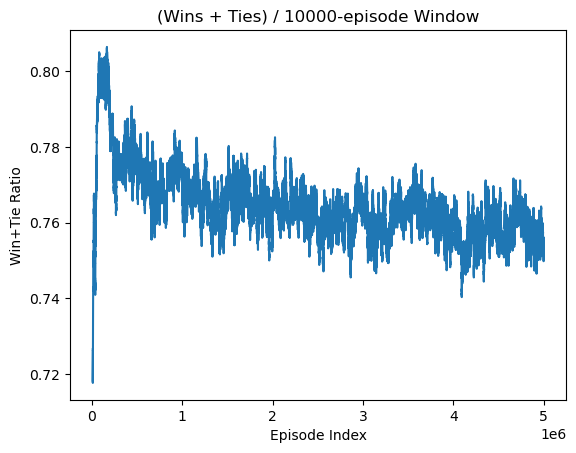

In [17]:
win_or_tie = episodes["final_reward"].eq(1.0) | episodes["final_reward"].eq(0.0)

# Sliding “win+tie” ratio
win_tie_ratio = win_or_tie.rolling(window=10000).mean()

# Plot it
import matplotlib.pyplot as plt

plt.figure()
plt.plot(win_tie_ratio)
plt.title(f"(Wins + Ties) / {10000}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Win+Tie Ratio")
plt.show()

Text(0.5, 1.0, 'final reward moving window average')

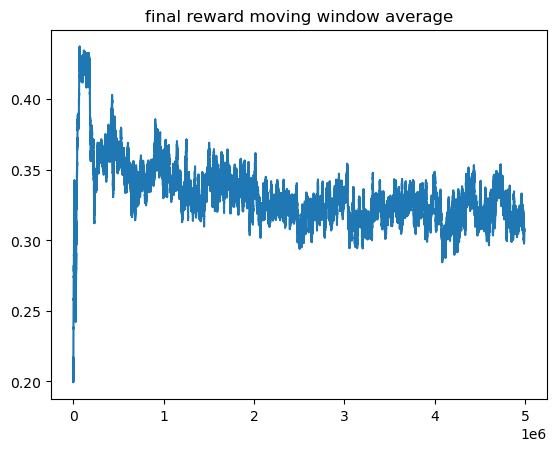

In [9]:
plt.plot(get_moving_window_average(episodes["final_reward"], window_size=10000))
plt.title("final reward moving window average")

Text(0.5, 1.0, 'mean td error moving window average')

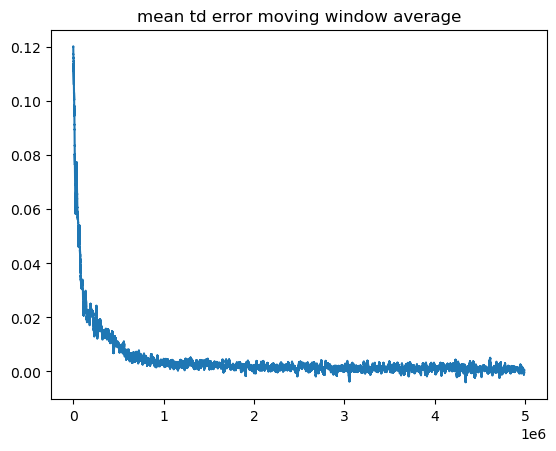

In [10]:
plt.plot(get_moving_window_average(episodes["mean_td_error"], window_size=10000))
plt.title("mean td error moving window average")

Text(0.5, 1.0, 'mean abs td error moving window average')

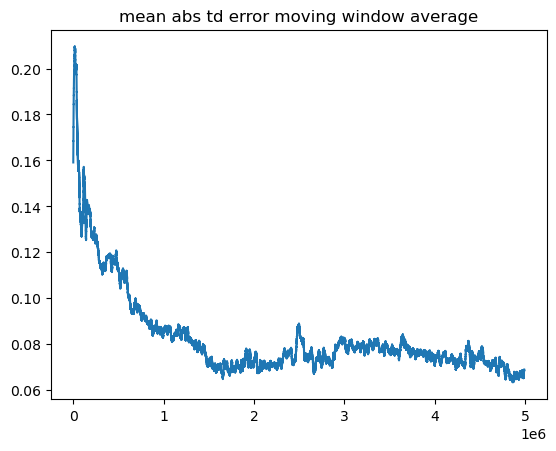

In [11]:
plt.plot(get_moving_window_average(episodes["mean_abs_td_error"], window_size=10000))
plt.title("mean abs td error moving window average")

Text(0.5, 1.0, 'mean squared td error moving window average')

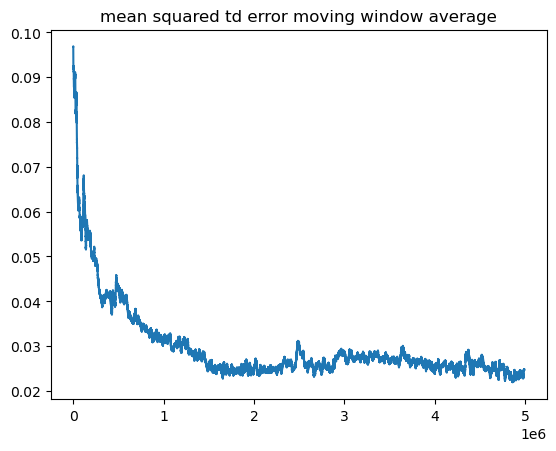

In [12]:
plt.plot(get_moving_window_average(episodes["mean_squared_td_error"], window_size=10000))
plt.title("mean squared td error moving window average")

Text(0.5, 1.0, 'max abs td error moving window average')

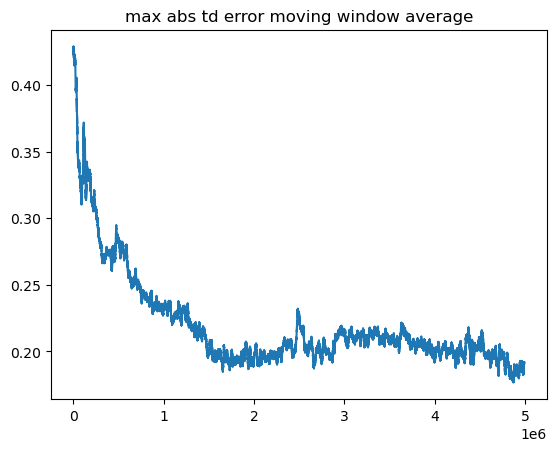

In [13]:
plt.plot(get_moving_window_average(episodes["max_abs_td_error"], window_size=10000))
plt.title("max abs td error moving window average")